In [1]:

from scipy.spatial.distance import jensenshannon
import numpy as np
import sys

sys.path.insert(0, '../scripts/')
from load_modify_sample_utils import load_model, get_objective_functions, get_reaction_bounds, modify_model, sample_gapsplit, plot_grid_95_reactions
from load_modify_sample_utils import sample_dingo, sample_optgp, sampling_statistics
from correlations_utils import compute_copula
from correlations_utils import plot_copula


/home/touliopoulos/.local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/touliopoulos/.local/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:

ec_cobra_model, ec_cobra_reactions, ec_dingo_model, ec_dingo_reactions = load_model("../ext_data/models/e_coli_core.xml")

objective_functions = get_objective_functions(ec_cobra_model)
print(objective_functions)

default_reaction_bounds = get_reaction_bounds(ec_cobra_model)
print(default_reaction_bounds)


Set parameter Username
Set parameter LicenseID to value 2642044
Academic license - for non-commercial use only - expires 2026-03-25
['BIOMASS_Ecoli_core_w_GAM']
{'PFK': (0.0, 1000.0), 'PFL': (0.0, 1000.0), 'PGI': (-1000.0, 1000.0), 'PGK': (-1000.0, 1000.0), 'PGL': (0.0, 1000.0), 'ACALD': (-1000.0, 1000.0), 'AKGt2r': (-1000.0, 1000.0), 'PGM': (-1000.0, 1000.0), 'PIt2r': (-1000.0, 1000.0), 'ALCD2x': (-1000.0, 1000.0), 'ACALDt': (-1000.0, 1000.0), 'ACKr': (-1000.0, 1000.0), 'PPC': (0.0, 1000.0), 'ACONTa': (-1000.0, 1000.0), 'ACONTb': (-1000.0, 1000.0), 'ATPM': (8.39, 1000.0), 'PPCK': (0.0, 1000.0), 'ACt2r': (-1000.0, 1000.0), 'PPS': (0.0, 1000.0), 'ADK1': (-1000.0, 1000.0), 'AKGDH': (0.0, 1000.0), 'ATPS4r': (-1000.0, 1000.0), 'PTAr': (-1000.0, 1000.0), 'PYK': (0.0, 1000.0), 'BIOMASS_Ecoli_core_w_GAM': (0.0, 1000.0), 'PYRt2': (-1000.0, 1000.0), 'CO2t': (-1000.0, 1000.0), 'RPE': (-1000.0, 1000.0), 'CS': (0.0, 1000.0), 'RPI': (-1000.0, 1000.0), 'SUCCt2_2': (0.0, 1000.0), 'CYTBD': (0.0, 1000.

In [12]:

ec_cobra_model_condition_1, ec_dingo_model_condition_1 = modify_model(ec_cobra_model, objective_function="BIOMASS_Ecoli_core_w_GAM", optimal_percentage=100)
ec_cobra_model_condition_2, ec_dingo_model_condition_2 = modify_model(ec_cobra_model, objective_function="BIOMASS_Ecoli_core_w_GAM", optimal_percentage=0)


samples_dingo_condition_1 = sample_dingo(ec_dingo_model_condition_1, reaction_in_rows = True, ess=2000)
print(samples_dingo_condition_1.shape)

samples_dingo_condition_2 = sample_dingo(ec_dingo_model_condition_2, reaction_in_rows = True, ess=2000)
print(samples_dingo_condition_2.shape)


Read LP format model from file /tmp/tmp2gu6tngh.lp
Reading time = 0.01 seconds
: 72 rows, 190 columns, 720 nonzeros
Read LP format model from file /tmp/tmpnyfid2gf.lp
Reading time = 0.00 seconds
: 72 rows, 190 columns, 720 nonzeros
phase 1: number of correlated samples = 500, effective sample size = 3, ratio of the maximum singilar value over the minimum singular value = 2282.89
phase 2: number of correlated samples = 500, effective sample size = 3, ratio of the maximum singilar value over the minimum singular value = 241.931
phase 3: number of correlated samples = 500, effective sample size = 16, ratio of the maximum singilar value over the minimum singular value = 273.189
phase 4: number of correlated samples = 500, effective sample size = 151, ratio of the maximum singilar value over the minimum singular value = 17.9171
phase 5: number of correlated samples = 500, effective sample size = 203, ratio of the maximum singilar value over the minimum singular value = 2.74455
phase 6: numb

[5]maximum marginal PSRF: 1.1135


phase 1: number of correlated samples = 500, effective sample size = 5, ratio of the maximum singilar value over the minimum singular value = 1162.68
phase 2: number of correlated samples = 500, effective sample size = 178, ratio of the maximum singilar value over the minimum singular value = 2.21316
phase 3: number of correlated samples = 2400, effective sample size = 863
phase 4: number of correlated samples = 2400, effective sample size = 937
phase 5: number of correlated samples = 100, effective sample size = 25
[5]total ess 2008: number of correlated samples = 5900


(95, 5900)


[5]maximum marginal PSRF: 1.00117


In [61]:


def copula_tail_dependence_test(copula, cop_coeff_1, cop_coeff_2, cop_coeff_3, indicator_cutoff):

    rows, cols = copula.shape
    
    red_mass = 0
    blue_mass = 0
        
    top_left_count = 0
    bottom_right_count = 0
    top_right_count = 0
    bottom_left_count = 0
    
    top_left = []
    bottom_right = []
    top_right = []
    bottom_left = []
    
                    
    for row in range(rows):
        for col in range(cols):
            # values in the diagonal
            if ((row-col >= -cop_coeff_1*rows) & (row-col <= cop_coeff_1*rows)): 
                # values near the top left
                if (row+col < cop_coeff_2*rows -1):
                    red_mass = red_mass + copula[row][col]       
                    top_left_count = top_left_count + 1
                    top_left.append((row, col))
                    
                # values near the bottom right
                elif (row+col > cop_coeff_3*rows -1):
                    red_mass = red_mass + copula[row][col]       
                    bottom_right_count = bottom_right_count + 1
                    bottom_right.append((row, col))
            
            # values in the other diagonal
            else:
                # values near the top right and bottom left corner
                if (row+col >= cop_coeff_2*rows -1) & (row+col <= cop_coeff_3*rows -1):                    
                    # values near the top right
                    if row < rows / 2:
                        blue_mass = blue_mass + copula[row][col]       
                        top_right_count = top_right_count + 1
                        top_right.append((row, col))
                    
                    # values near the bottom left
                    elif row >= rows / 2:
                        blue_mass = blue_mass + copula[row][col]       
                        bottom_left_count = bottom_left_count + 1
                        bottom_left.append((row, col))
                                                

    #print(top_left, "\n", bottom_right, "\n", top_right, "\n" , bottom_left)
    print(top_left_count, bottom_right_count, top_right_count, bottom_left_count)
    print(red_mass/blue_mass)
    print(red_mass, blue_mass)

    

n = 4
copula = np.zeros((n, n))

cop_coeff = 0.2
cop_coeff_1 = cop_coeff
cop_coeff_2 = 1 - cop_coeff
cop_coeff_3 = 1 + cop_coeff

n1 = ec_dingo_reactions.index("PGK")
n2 = ec_dingo_reactions.index("PFK")

flux1 = np.absolute(samples_dingo_condition_2[n1])
flux2 = np.absolute(samples_dingo_condition_2[n2])
flux1 = samples_dingo_condition_2[n1]
flux2 = samples_dingo_condition_2[n2]

data_flux1=[flux1,ec_dingo_reactions[n1]]
data_flux2=[flux2,ec_dingo_reactions[n2]]


print( np.corrcoef(flux1, flux2) )
print(np.min(flux1), np.max(flux1))
print(np.min(flux2), np.max(flux2))


plot_copula(data_flux1, data_flux2, n = n)


copula = compute_copula(flux1, flux2, n = n)
copula_tail_dependence_test(copula, cop_coeff_1, cop_coeff_2, cop_coeff_3, indicator_cutoff=1)



[[ 1.         -0.23043217]
 [-0.23043217  1.        ]]
-19.957209513755775 -8.10111899176817
0.7970710748256696 75.09468537721811


2 2 2 2
0.5748987854251013
0.19254237288135595 0.33491525423728813


In [ ]:


cells = 5
reference_copula = np.full( (cells, cells), (1 / (cells*cells)) )
reference_copula_1_flat = reference_copula.flatten()


reference_copula_2 = np.array([[0.25, 0.25, 0, 0, 0],
                               [0.25, 0.25, 0, 0, 0],
                               [0, 0, 0,  0, 0],
                               [0, 0, 0,  0, 0],
                               [0, 0, 0, 0,  0]])


reference_copula_2_flat = reference_copula_2.flatten()


reference_copula_3 = np.array([[1, 0, 0, 0, 0],
                               [0, 0, 0, 0, 0],
                               [0, 0, 0,  0, 0],
                               [0, 0, 0,  0, 0],
                               [0, 0, 0, 0,  0]])

reference_copula_3_flat = reference_copula_3.flatten()


# Compute Jensen-Shannon distance (range: 0 to 1)
dist = jensenshannon(reference_copula_1_flat, reference_copula_1_flat)
print(dist)

dist = jensenshannon(reference_copula_1_flat, reference_copula_2_flat)
print(dist)

dist = jensenshannon(reference_copula_1_flat, reference_copula_3_flat)
print(dist)



0.0
0.6785698641197397
0.7799839057460577


In [ ]:
import numpy as np
cells = 100

a = np.zeros((cells,cells))

b = a.copy()
b[0,0] = 1
b_flat = b.flatten()

c = a.copy()
c[:10, :10] = 0.01
c_flat = c.flatten()

reference_copula = np.full( (cells, cells), (1 / (cells*cells)) )
reference_copula_flat = reference_copula.flatten()

array([1., 0., 0., ..., 0., 0., 0.])

In [ ]:
from scipy.spatial.distance import jensenshannon

dist = jensenshannon(b_flat, reference_copula_flat)
print(dist)

dist = jensenshannon(c_flat, reference_copula_flat)
print(dist)

0.8322479564657576
0.8155344336992489


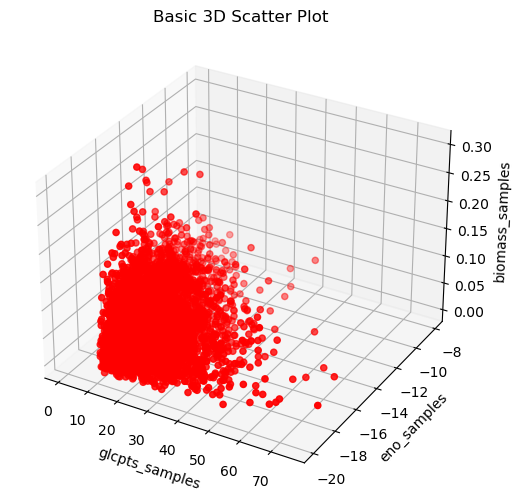

<Figure size 800x600 with 0 Axes>

In [42]:

import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

glcpts = ec_dingo_reactions.index("GLCpts")
glcpts = ec_dingo_reactions.index("PFK")

eno = ec_dingo_reactions.index("ENO")
eno = ec_dingo_reactions.index("PGK")

biomass = ec_dingo_reactions.index("BIOMASS_Ecoli_core_w_GAM")



data_flux1=[samples_dingo_condition_2[glcpts],ec_dingo_reactions[glcpts]]
data_flux2=[samples_dingo_condition_2[eno],ec_dingo_reactions[eno]]
data_flux3=[samples_dingo_condition_2[biomass],ec_dingo_reactions[biomass]]

plot_copula(data_flux1, data_flux2, n=20)
plot_copula(data_flux1, data_flux3, n=20)
plot_copula(data_flux2, data_flux3, n=20)



glcpts_samples = samples_dingo_condition_2[glcpts]
eno_samples = samples_dingo_condition_2[eno]
biomass_samples = samples_dingo_condition_2[biomass]



fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')

# Create scatter plot
ax.scatter3D(xs=glcpts_samples, ys=eno_samples, zs=biomass_samples, color='red', marker='o')

# Labels
ax.set_xlabel('glcpts_samples')
ax.set_ylabel('eno_samples')
ax.set_zlabel('biomass_samples')
ax.set_title('Basic 3D Scatter Plot')

plt.show()



fig = plt.figure(figsize=(8,6))
df = pd.DataFrame({
    'glcpts_samples': glcpts_samples,
    'eno_samples': eno_samples,
    'biomass_samples': biomass_samples
})


fig = px.scatter_3d(df, 
                    x='glcpts_samples', 
                    y='eno_samples', 
                    z='biomass_samples',
                    opacity=0.7)
fig.show()


[[1.         0.14959572]
 [0.14959572 1.        ]]
SignificanceResult(statistic=0.5769323436373768, pvalue=0.0)


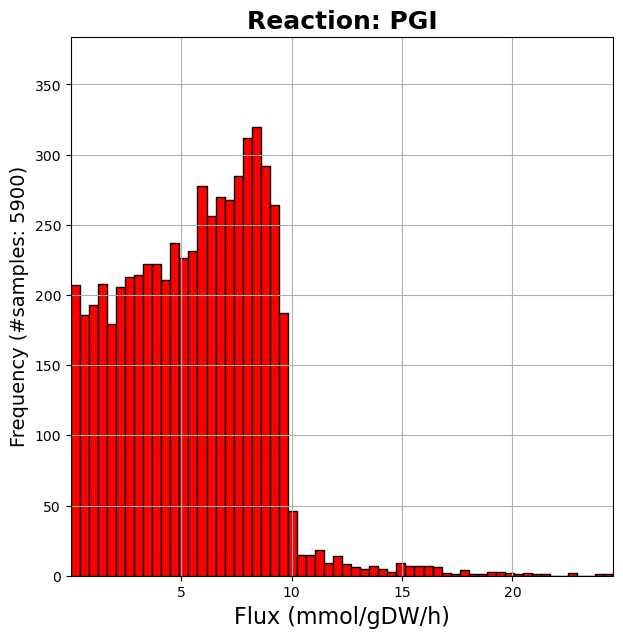

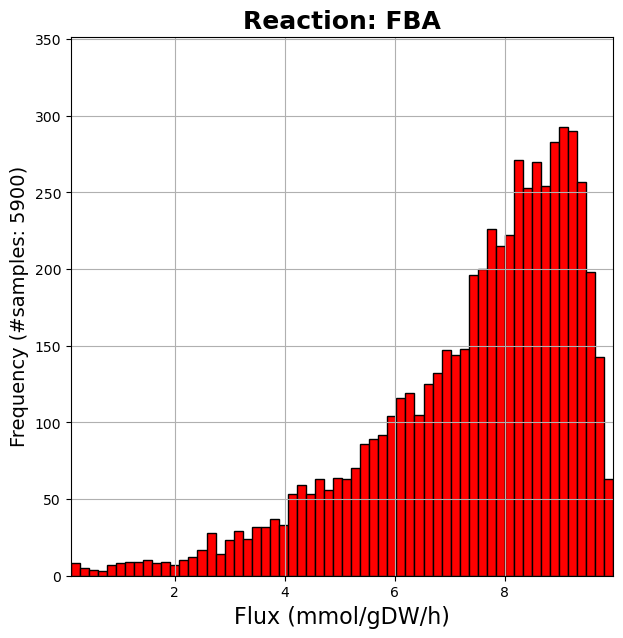

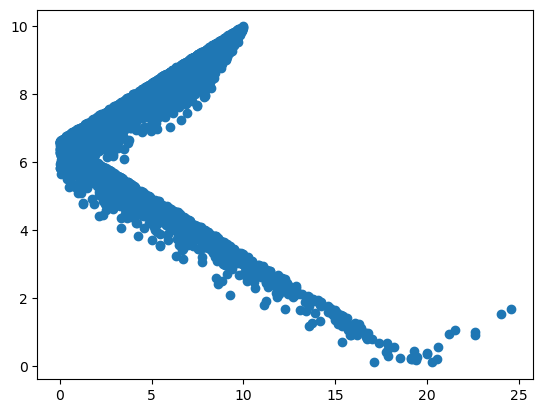

0.8606646320252257


In [ ]:

from dingo import plot_histogram
from scipy.stats import spearmanr


n1 = ec_dingo_reactions.index("PGI")
n2 = ec_dingo_reactions.index("PGL")
n2 = ec_dingo_reactions.index("FBA")


flux1 = np.absolute(samples_dingo_condition_2[n1])
flux2 = np.absolute(samples_dingo_condition_2[n2])
#flux1 = samples_dingo_condition_2[n1]
#flux2 = samples_dingo_condition_2[n2]


print( np.corrcoef(flux1, flux2) )
print( spearmanr(flux1, flux2) )


plot_histogram(flux1,
               ec_dingo_reactions[n1],
               n_bins = 60)


plot_histogram(flux2,
               ec_dingo_reactions[n2],
               n_bins = 60)


plt.scatter(flux1, flux2)
plt.show()


